### **1. Analisis datos de venta**

A fin de poder crear un modelo adecuado para la optimización de precios, 
iniciamos con un análisis descriptivo de los datos, donde podremos ver 
las métricas básicas de cada variable, sus valores agrupados, los datos 
derivados y finalmente las tendencias de ventas y ganancia de cada 
producto. 

Los siguientes pasos fueron tomados en esta libreta:

1. Carga de datos y vistazo inicial
2. Preprocesamiento: limpieza, renombramiento y columnas calculadas
3. Análisis de los datos: Estadísticas, agregaciones, tendencias

In [1]:
# Step 0. Load libraries and custom functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Iniciamos con la carga de datos y la exploración básica de los mismos, 
con una muestra simple y reproducible para el lector.

In [2]:
# Step 1. Load dataset
# 1.1 Read csv and show basic info
df_raw = pd.read_csv('../data/ventas.csv', engine='python', encoding='latin-1')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10879 entries, 0 to 10878
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fecha             10879 non-null  object 
 1   Cdigo            10879 non-null  int64  
 2   Descripcin       10879 non-null  object 
 3   Precio Unitario   10879 non-null  float64
 4   Costo Unitario    10879 non-null  float64
 5   Cantidad Vendida  10879 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 510.1+ KB


In [3]:
# 1.2 Show a sample of the dataset
df_raw.sample(10, random_state=2024)

,Fecha,Cdigo,Descripcin,Precio Unitario,Costo Unitario,Cantidad Vendida
10849,2024-06,10121151,BIPACK NOSOTRAS 2 INV DEO 10UN,18.2,17.98,5.0
3320,2023-05,100714,HUEVO ROLON M.CORTADO 12U,12.9,10.00,9.0
1150,2022-42,10108320,CHOCOLATE SUBLIME CLASICO 100GR,12.5,12.00,1.0
7147,2022-43,10000095,GASEOSA PEPSI 500ML,3.5,3.22,28.0
6449,2023-25,10022018,PAPEL HIG CONFORT 12UN,74.1,63.71,5.0
4029,2022-19,10083638,CERVEZA HUARI MIEL 330ML,11.0,8.73,29.0
3289,2023-02,100714,HUEVO ROLON M.CORTADO 12U,12.9,10.00,6.0
4391,2023-04,10083638,CERVEZA HUARI MIEL 330ML,11.0,8.73,53.0
7573,2023-37,10000095,GASEOSA PEPSI 500ML,3.5,3.22,68.0
4741,2023-40,10083638,CERVEZA HUARI MIEL 330ML,10.9,8.73,26.0


A primera vista disponemos de un dataset con precio, costo y cantidad 
vendida. Vemos también que las tildes han sido omitidas, por lo que 
utilizaremos un formato ASCII estándar para los nombre de columnas, con 
el estilo serpiente (es decir con líneas bajas en vez de espacios). 

Podemos asimismo observar que la fecha es un texto que debe convertirse 
a formato 'datetime', y que podemos crear columnas calculadas como la 
ganancia, que es la diferencia entre el precio unitario y el costo 
multiplicado por la cantidad vendida.

In [4]:
# Step 2. Preprocess data to format columns
# 2.1 Create a copy of the raw data
df_interim = df_raw.reset_index(drop=True).copy()

In [5]:
# 2.2 Rename columns
df_interim = df_interim.rename(columns={df_interim.columns[1]:'Codigo',
                                        df_interim.columns[2]:'Descripcion',
                                        df_interim.columns[3]:'Precio_Unitario',
                                        df_interim.columns[4]:'Costo_Unitario',
                                        df_interim.columns[5]:'Cantidad_Vendida'})
df_interim.columns

Index(['Fecha', 'Codigo', 'Descripcion', 'Precio_Unitario', 'Costo_Unitario',
       'Cantidad_Vendida'],
      dtype='object')

In [6]:
# 2.3 Format dates
df_interim['Fecha_Formato'] = pd.to_datetime(df_interim['Fecha'] + '-1', format='%Y-%W-%w')
df_interim.sample(5, random_state=2024)

,Fecha,Codigo,Descripcion,Precio_Unitario,Costo_Unitario,Cantidad_Vendida,Fecha_Formato
10849,2024-06,10121151,BIPACK NOSOTRAS 2 INV DEO 10UN,18.2,17.98,5.0,2024-02-05
3320,2023-05,100714,HUEVO ROLON M.CORTADO 12U,12.9,10.00,9.0,2023-01-30
1150,2022-42,10108320,CHOCOLATE SUBLIME CLASICO 100GR,12.5,12.00,1.0,2022-10-17
7147,2022-43,10000095,GASEOSA PEPSI 500ML,3.5,3.22,28.0,2022-10-24
6449,2023-25,10022018,PAPEL HIG CONFORT 12UN,74.1,63.71,5.0,2023-06-19


In [7]:
# 2.4 Format code
df_interim['Codigo'] = df_interim['Codigo'].astype(str)
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10879 entries, 0 to 10878
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha             10879 non-null  object        
 1   Codigo            10879 non-null  object        
 2   Descripcion       10879 non-null  object        
 3   Precio_Unitario   10879 non-null  float64       
 4   Costo_Unitario    10879 non-null  float64       
 5   Cantidad_Vendida  10879 non-null  float64       
 6   Fecha_Formato     10879 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 595.1+ KB


In [8]:
# 2.5 Create profit column
df_interim['Ganancia'] = (df_interim['Precio_Unitario'] - df_interim['Costo_Unitario']) * df_interim['Cantidad_Vendida']
df_interim.sample(5, random_state=2024)

,Fecha,Codigo,Descripcion,Precio_Unitario,Costo_Unitario,Cantidad_Vendida,Fecha_Formato,Ganancia
10849,2024-06,10121151,BIPACK NOSOTRAS 2 INV DEO 10UN,18.2,17.98,5.0,2024-02-05,1.10
3320,2023-05,100714,HUEVO ROLON M.CORTADO 12U,12.9,10.00,9.0,2023-01-30,26.10
1150,2022-42,10108320,CHOCOLATE SUBLIME CLASICO 100GR,12.5,12.00,1.0,2022-10-17,0.50
7147,2022-43,10000095,GASEOSA PEPSI 500ML,3.5,3.22,28.0,2022-10-24,7.84
6449,2023-25,10022018,PAPEL HIG CONFORT 12UN,74.1,63.71,5.0,2023-06-19,51.95


In [9]:
# 2.6 Set formatted date as index
df_interim = df_interim.set_index(['Fecha_Formato'])

In [10]:
# 2.7 Save the dataframe for analysis purposes
df = df_interim.copy()
df.to_csv('../data/ventas_final.csv')

Con las conversiones hechas en esta etapa de preprocesamiento, hemos 
generado un nuevo dataset, el cual hemos guardado como datos limpios para 
el proceso de análisis exploratorio de datos (EDA por sus siglas en inglés).

El procedimiento básico de EDA es el siguiente:
1. Vista de tipos de datos, número de filas y columnas y valores nulos
2. Obtener las estádisticas básicas de medidas de tendencia central, dispersión, valores únicos y conteo
3. Cálculo de valores agregados de las columnas de unidades vendidas, precio y ganancia
4. Descriptores de productos como ganancia agregada
5. Gráficas de métricas en el tiempo y la tendencia 

In [11]:
# Step 3. Exploratory Data Analysis
# 3.1 Get basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10879 entries, 2022-01-03 to 2024-02-19
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fecha             10879 non-null  object 
 1   Codigo            10879 non-null  object 
 2   Descripcion       10879 non-null  object 
 3   Precio_Unitario   10879 non-null  float64
 4   Costo_Unitario    10879 non-null  float64
 5   Cantidad_Vendida  10879 non-null  float64
 6   Ganancia          10879 non-null  float64
dtypes: float64(4), object(3)
memory usage: 679.9+ KB


In [12]:
# 3.2 Get basic statistics
print('Tabla 1. Estadísticas de valores numéricos')
df.describe()

Tabla 1. Estadísticas de valores numéricos


,Precio_Unitario,Costo_Unitario,Cantidad_Vendida,Ganancia
count,10879.000000,10879.000000,10879.000000,10879.000000
mean,15.945583,14.172863,17.850344,15.555206
std,19.302433,17.898202,24.058339,50.458713
min,1.400000,1.400000,0.440000,-1588.150000
25%,4.000000,3.220000,4.000000,3.000000
50%,10.900000,8.730000,10.000000,9.360000
75%,15.900000,12.200000,22.000000,24.000000
max,74.100000,63.710000,354.000000,463.080000


Uno de los puntos llamativos que observamos en la tabla 1 mostrada arriba 
es que tenemos productos a pérdida (de acuerdo a la columna Ganancia), lo 
cual suele ser utilizado para descargar inventario con poco movimiento, 
o para apuntalar otros productos [1]. Otro aspecto llamativo es que 
algunas cantidades son fraccionales, lo cual puede referirse a productos 
vendidos al peso. Dado que son datos agregados, procederemos luego a ver 
sus estadísticas por producto. 

In [13]:
print('Tabla 2. Estadísticas de valores categóricos')
df.describe(include='object')

Tabla 2. Estadísticas de valores categóricos


,Fecha,Codigo,Descripcion
count,10879,10879,10879
unique,112,12,12
top,2022-10,100714,HUEVO ROLON M.CORTADO 12U
freq,112,1060,1060


En la tabla 2 podemos observar que tenemos 12 productos únicos, los 
cuales coinciden con el código, y que el producto má frecuente es el 
100714, con 1060 ocurrencias. La fecha de más movimiento es octubre del 
2022 con 112 ocurrencias. 

In [14]:
# 3.3 Get a sample
df.sample(5, random_state=2024)

,Fecha,Codigo,Descripcion,Precio_Unitario,Costo_Unitario,Cantidad_Vendida,Ganancia
Fecha_Formato,,,,,,,
2024-02-05,2024-06,10121151,BIPACK NOSOTRAS 2 INV DEO 10UN,18.2,17.98,5.0,1.10
2023-01-30,2023-05,100714,HUEVO ROLON M.CORTADO 12U,12.9,10.00,9.0,26.10
2022-10-17,2022-42,10108320,CHOCOLATE SUBLIME CLASICO 100GR,12.5,12.00,1.0,0.50
2022-10-24,2022-43,10000095,GASEOSA PEPSI 500ML,3.5,3.22,28.0,7.84
2023-06-19,2023-25,10022018,PAPEL HIG CONFORT 12UN,74.1,63.71,5.0,51.95


Ahora procedemos a analizar las métricas generales de cantidad, ganancia 
y ocurrencias, por año, tomando en cuenta que el año 2024 está incompleto. 

In [15]:
# 3.4 Show the products sold by quantity, by year
df.resample('YE')['Cantidad_Vendida'].sum()

Fecha_Formato
2022-12-31    90846.37
2023-12-31    92902.69
2024-12-31    10444.83
Freq: YE-DEC, Name: Cantidad_Vendida, dtype: float64

In [16]:
# 3.5 Show the products sold by revenue, by year
df.resample('YE')['Ganancia'].sum()

Fecha_Formato
2022-12-31    58336.7880
2023-12-31    99584.3815
2024-12-31    11303.9175
Freq: YE-DEC, Name: Ganancia, dtype: float64

Aunque el 2022 y 2023 tuvieron cantidades vendidas de productos similares, 
la ganancia del 2023 fue mayor. 

In [17]:
# 3.6 Show the quantity of occurrences, by year
df.resample('YE')['Cantidad_Vendida'].count()

Fecha_Formato
2022-12-31    5023
2023-12-31    5099
2024-12-31     757
Freq: YE-DEC, Name: Cantidad_Vendida, dtype: int64

Ahora procederemos a desagregar estas métricas por producto y por año, 
de manera que podamos entender como se comparan y que productos aportaron 
más en la ganancia en el 2023. 

In [18]:
# 3.7 Show the detail of products revenue, by year 
df.groupby([df.index.year, 'Descripcion'])['Ganancia'].agg(['sum'])

sum
Fecha_Formato Descripcion                                
2022          ALIM. BEB.DE SOYA BANA            4194.0000
              BIPACK NOSOTRAS  2 INV DEO 10UN  -8719.2400
              CERVEZA HUARI MIEL 330ML         44338.5100
              CHOCOLATE SUBLIME CLASICO 100GR   3220.5500
              GASEOSA PEPSI 500ML               6455.9000
              HUEVO ROLON M.CORTADO 12U         6188.7000
              JUGO PIL MANZ CLASIC TETR         8615.9500
              JUGO PIL PINA ETRA 150ML          5611.9000
              LECHE EVAPORADA B B UHT 400G     -4647.9000
              NESTLE CLASSIC MILK 80G           3940.3000
              PAPEL HIG CONFORT 12UN          -15799.1100
              PORK BELLY CONGELADO SOFI         4937.2280
2023          ALIM. BEB.DE SOYA BANA            4787.5000
              BIPACK NOSOTRAS  2 INV DEO 10UN  -7834.1700
              CERVEZA HUARI MIEL 330ML         27700.5600
              CHOCOLATE SUBLIME CLASICO 100GR   4657.7000
              GASEOSA PEPSI 500ML               8216.0800
              HUEVO ROLON M.CORTADO 12U        33388.3000
              JUGO PIL MANZ CLASIC TETR         7914.4000
              JUGO PIL PINA ETRA 150ML          5645.1000
              LECHE EVAPORADA B B UHT 400G      1316.0000
              NESTLE CLASSIC MILK 80G           3315.1000
              PAPEL HIG CONFORT 12UN            5746.7400
              PORK BELLY CONGELADO SOFI         4731.0715
2024          ALIM. BEB.DE SOYA BANA            1200.6000
              BIPACK NOSOTRAS  2 INV DEO 10UN     55.7000
              CERVEZA HUARI MIEL 330ML           674.8700
              CHOCOLATE SUBLIME CLASICO 100GR   1084.2000
              GASEOSA PEPSI 500ML               1097.5200
              HUEVO ROLON M.CORTADO 12U         3548.0000
              JUGO PIL MANZ CLASIC TETR         1146.0000
              JUGO PIL PINA ETRA 150ML           671.4000
              LECHE EVAPORADA B B UHT 400G      2008.0000
              NESTLE CLASSIC MILK 80G            519.8000
              PAPEL HIG CONFORT 12UN           -2064.6700
              PORK BELLY CONGELADO SOFI         1362.4975

In [19]:
print('Figura 1. Ganancia generada por producto, por año')
temp_df = df.groupby([df.index.year, 'Descripcion'])['Ganancia'].\
    agg(['sum']).reset_index().\
        rename(columns={'Fecha_Formato':'Anho', 'sum':'Ganancia'}).\
        astype({'Anho': 'str', 'Ganancia': 'float64'})
px.bar(temp_df, x='Anho', y='Ganancia', color='Descripcion')

Figura 1. Ganancia generada por producto, por año


Podemos observar que uno de los proudctos con mayor aporte a las ganancias 
ha sido el huevo rolón, y el producto que se recuperó fue el papel hig 
que paso de pérdida a ganandia. El bipack nosotras es el que el 2022 y 
2023 tiene pérdidas consecutivas.

In [20]:
# 3.8 Show the detail of sold products quantity, by year 
df.groupby([df.index.year, 'Descripcion'])['Cantidad_Vendida'].agg(['sum'])

sum
Fecha_Formato Descripcion                              
2022          ALIM. BEB.DE SOYA BANA            5300.00
              BIPACK NOSOTRAS  2 INV DEO 10UN   2403.00
              CERVEZA HUARI MIEL 330ML         21978.00
              CHOCOLATE SUBLIME CLASICO 100GR   2387.00
              GASEOSA PEPSI 500ML              12785.00
              HUEVO ROLON M.CORTADO 12U         7532.00
              JUGO PIL MANZ CLASIC TETR        16259.00
              JUGO PIL PINA ETRA 150ML         10605.00
              LECHE EVAPORADA B B UHT 400G      6057.00
              NESTLE CLASSIC MILK 80G           1235.00
              PAPEL HIG CONFORT 12UN            3926.00
              PORK BELLY CONGELADO SOFI          379.37
2023          ALIM. BEB.DE SOYA BANA            3709.00
              BIPACK NOSOTRAS  2 INV DEO 10UN   3969.00
              CERVEZA HUARI MIEL 330ML         16183.00
              CHOCOLATE SUBLIME CLASICO 100GR   1569.00
              GASEOSA PEPSI 500ML              14086.00
              HUEVO ROLON M.CORTADO 12U         9375.00
              JUGO PIL MANZ CLASIC TETR        17858.00
              JUGO PIL PINA ETRA 150ML         12861.00
              LECHE EVAPORADA B B UHT 400G      9507.00
              NESTLE CLASSIC MILK 80G            961.00
              PAPEL HIG CONFORT 12UN            2466.00
              PORK BELLY CONGELADO SOFI          358.69
2024          ALIM. BEB.DE SOYA BANA             806.00
              BIPACK NOSOTRAS  2 INV DEO 10UN    845.00
              CERVEZA HUARI MIEL 330ML           311.00
              CHOCOLATE SUBLIME CLASICO 100GR    282.00
              GASEOSA PEPSI 500ML               1609.00
              HUEVO ROLON M.CORTADO 12U         1420.00
              JUGO PIL MANZ CLASIC TETR         1910.00
              JUGO PIL PINA ETRA 150ML          1119.00
              LECHE EVAPORADA B B UHT 400G      1259.00
              NESTLE CLASSIC MILK 80G            134.00
              PAPEL HIG CONFORT 12UN             647.00
              PORK BELLY CONGELADO SOFI          102.83

In [21]:
print('Figura 2. Cantidad vendida por producto, por año')
temp_df = df.groupby([df.index.year, 'Descripcion'])['Cantidad_Vendida'].\
    agg(['sum']).reset_index().\
        rename(columns={'Fecha_Formato':'Anho', 'sum':'Cantidad_Vendida'}).\
        astype({'Anho': 'str', 'Cantidad_Vendida': 'float64'})
px.bar(temp_df, x='Anho', y='Cantidad_Vendida', color='Descripcion')

Figura 2. Cantidad vendida por producto, por año


En la figura 2 observamos que la leche evaporada, el jugo de pina y el 
huevo rolón son de los productos que crecieron entre el 2022 al 2023. 

Ahora procederemos a ver el desempeño semanal por cada producto, en las 
métricas de cantidad vendida, ganancia y precio. Debido al efecto de picos 
en las cantidades, he procedido a  

Figura 3. Cantidad de producto vendido, por semana


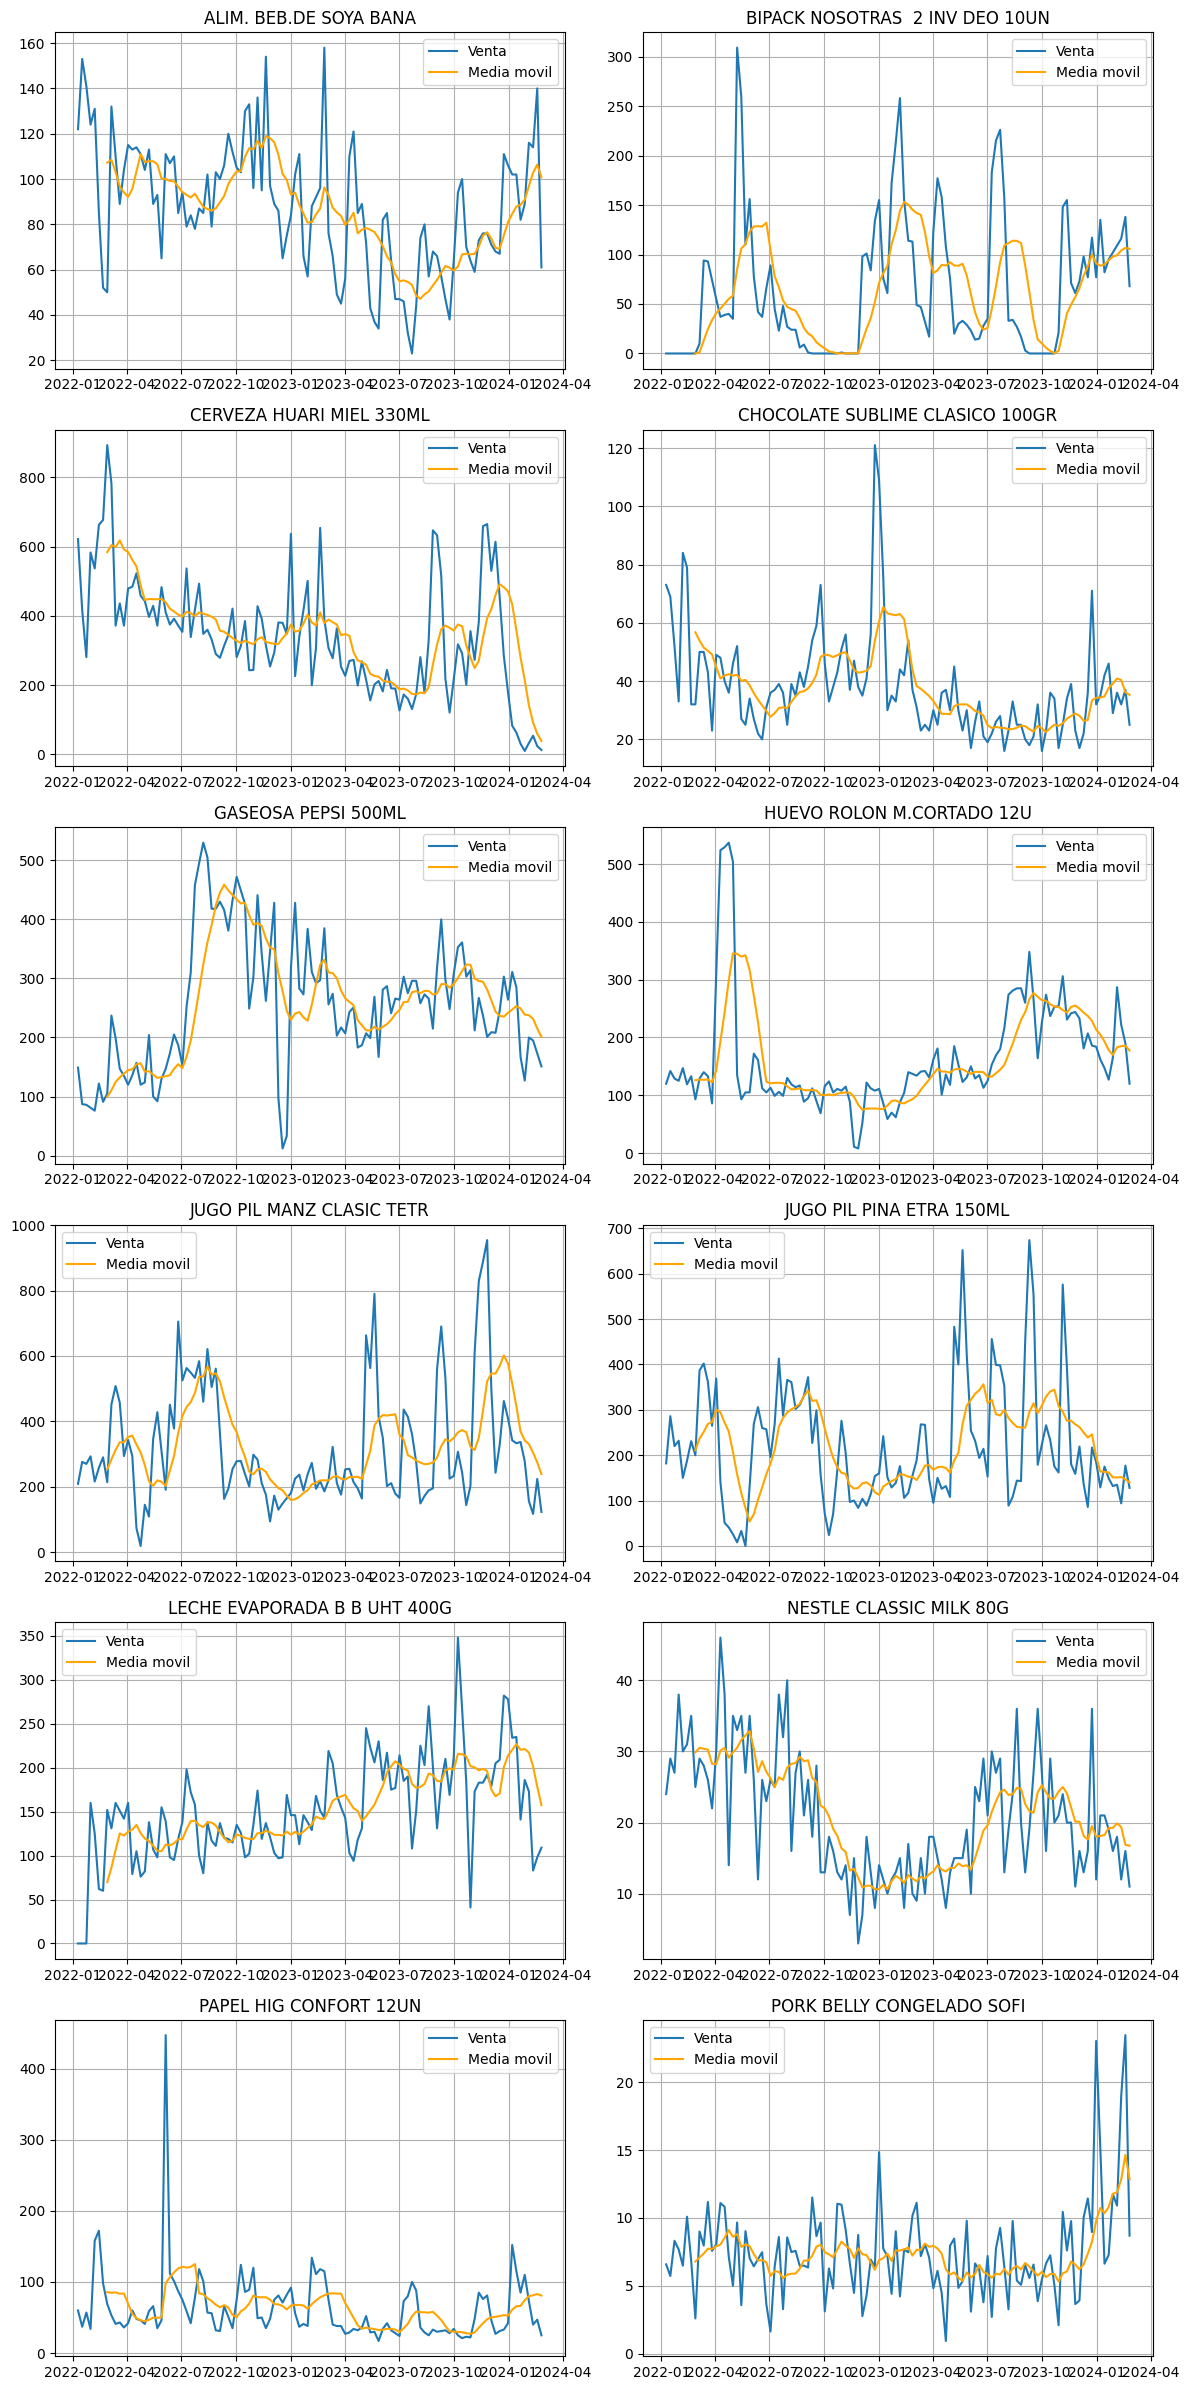

In [22]:
# 3.9 Plot trends on quantity, by product and week
df_quantity = df[['Descripcion','Cantidad_Vendida']].pivot_table(
    index=df.index,
    columns='Descripcion',
    values='Cantidad_Vendida',
    aggfunc='sum',
).resample('W', level=0).sum()

print('Figura 3. Cantidad de producto vendido, por semana')
fig, axs = plt.subplots(6,2, figsize=(12,24))
for i, ax in enumerate(axs.flatten()):
    temp_df = df_quantity.iloc[:,i]
    temp_df['rolling'] = temp_df.rolling(8).mean()
    ax.plot(df_quantity.iloc[:,i], label='Venta')
    ax.plot(temp_df['rolling'], c='orange', label='Media movil')
    ax.set_title(df_quantity.columns[i])
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.show()

En la figura 3 observamos el desempeño semanal de cantidad vendida por 
semana. Podemos observar que el último periodo ha sido a la baja en todos 
los productos, excepto en la leche evaporada. La media movil de 8 periodos 
muestra una tendencia más suavizada que puede servir para entender siguientes 
periodos.

Ahora procedemos al generar unas gráficas similares para las ganancias. En 
este caso, no será necesario el promedio móvil dado que son valores puntuales.

Figura 4. Ganancia por producto, por semana


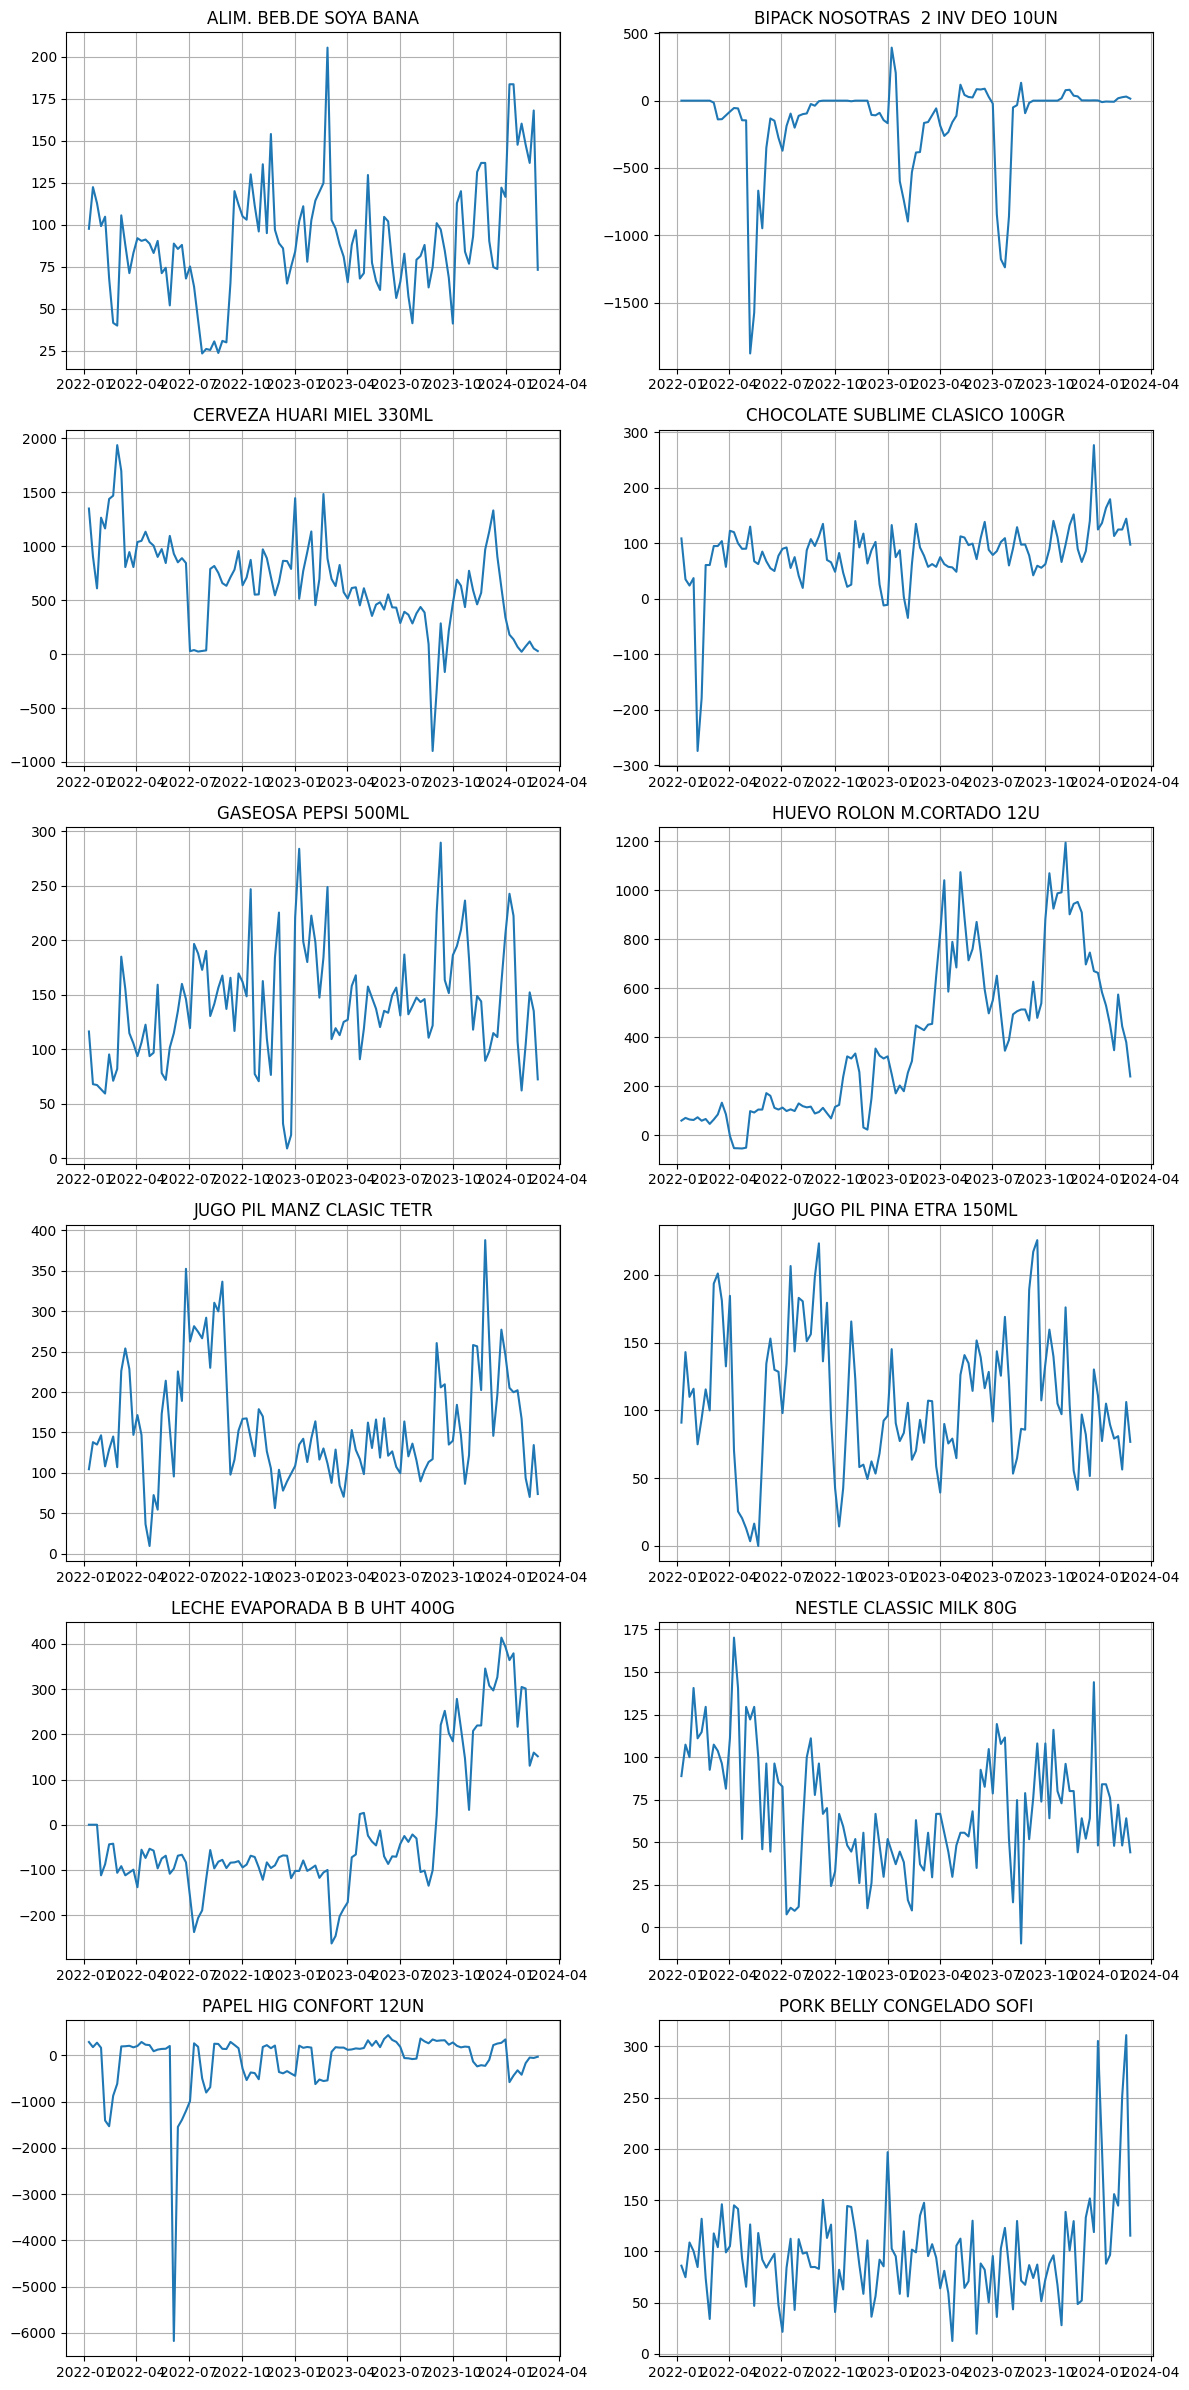

In [23]:
# 3.10 Plot trends on revenue, by product and week
df_revenue = df[['Descripcion','Ganancia']].pivot_table(
    index=df.index,
    columns='Descripcion',
    values='Ganancia',
    aggfunc='sum',
).resample('W', level=0).sum()

print('Figura 4. Ganancia por producto, por semana')

fig, axs = plt.subplots(6,2, figsize=(12,24))
for i, ax in enumerate(axs.flatten()):
    ax.plot(df_revenue.iloc[:,i])
    ax.set_title(df_revenue.columns[i])
    ax.grid(True)
plt.tight_layout()
plt.show()

En la figura 4 podemos observar como algunos la ganancia de algunos 
productos han ido al alza, como la bebida de soya, la lecha evaporada, 
la panceta de cerdo y el chocolate sublime levemente. Otros productos 
como el papel hig y el bipack nosotras han estado con pérdidas 
consistentes. 

Ahora veamos el precio de los productos, por fecha.

Figura 5. Ganancia por producto, por semana


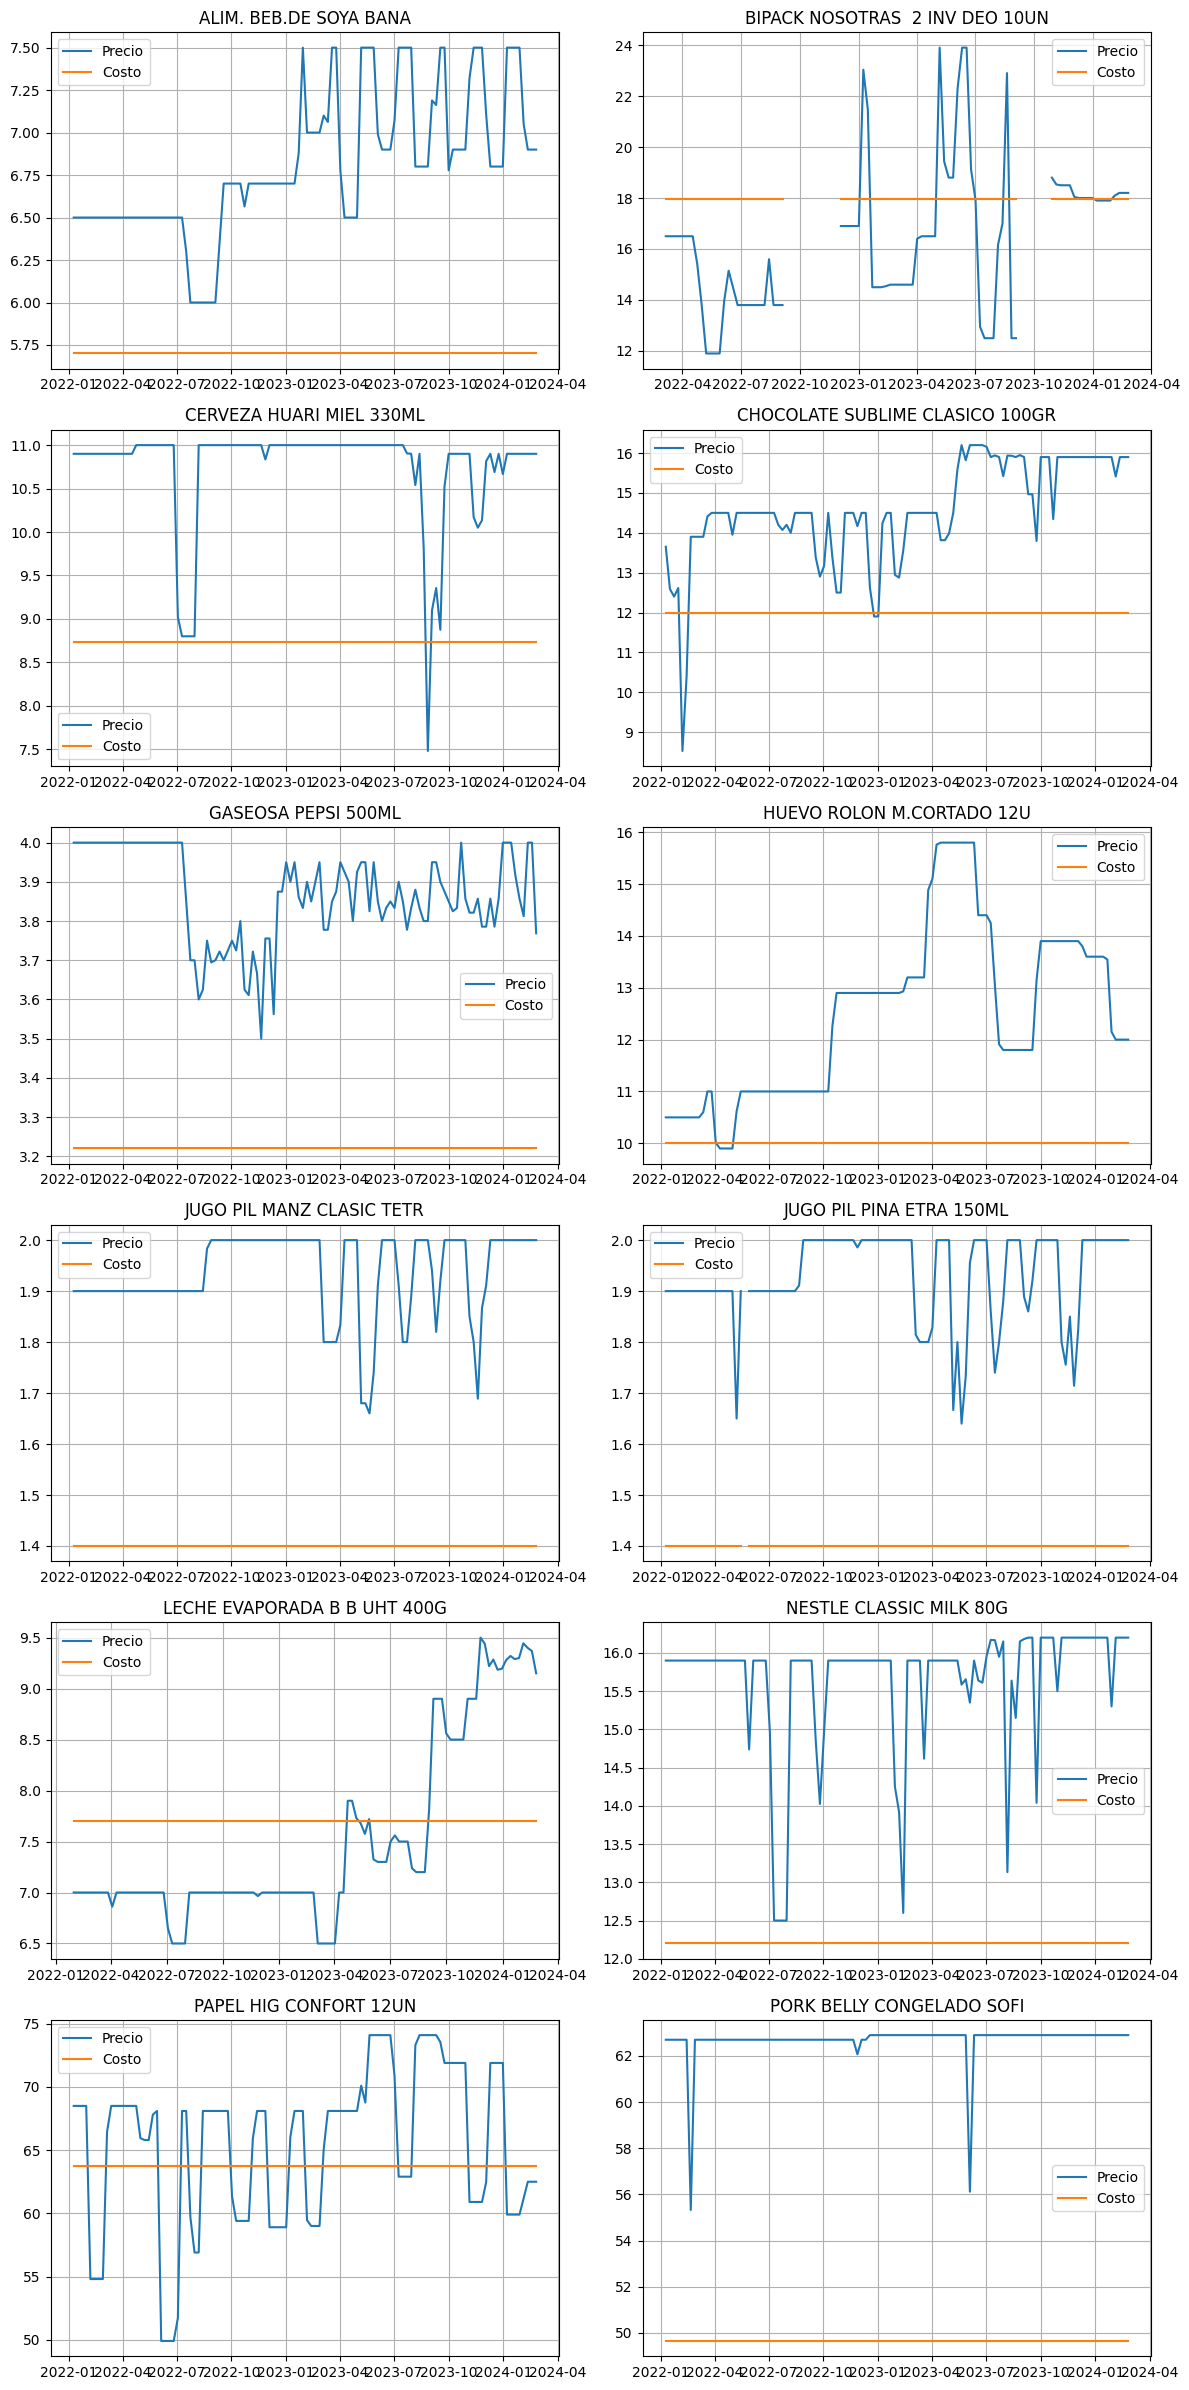

In [24]:
# 3.11 Plot trends on price, by product and week
df_price = df[['Descripcion','Precio_Unitario']].pivot_table(
    index=df.index,
    columns='Descripcion',
    values='Precio_Unitario',
    aggfunc='mean',
).resample('W', level=0).mean()

df_cost = df[['Descripcion','Costo_Unitario']].pivot_table(
    index=df.index,
    columns='Descripcion',
    values='Costo_Unitario',
    aggfunc='mean',
).resample('W', level=0).mean()

print('Figura 5. Ganancia por producto, por semana')

fig, axs = plt.subplots(6,2, figsize=(12,24))
for i, ax in enumerate(axs.flatten()):
    ax.plot(df_price.iloc[:,i], label='Precio')
    ax.plot(df_cost.iloc[:,i], label='Costo')
    ax.set_title(df_price.columns[i])
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.show()

En el caso de los precios, podemos ver algunos productos con bandas de 
precio estable, como la panceta de cerdo o el jugo pil pina. Otros 
productos como la leche evaporada y la bebida de soya han ido al alza. De 
igual manera se nota que la banda de costos es identica en todo el periodo, 
para todos los productos.

#### **Referencias**
[1] https://www.inc.com/karl-and-bill/selling-your-product-at-a-loss-can-be-good-for-business.html  
